In [15]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [16]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [17]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [18]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [19]:
wiki.invoke("what is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [20]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# Langsmith tracing
os.environ["LANGCHAIN_PROJECT_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [21]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args: 
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Add a and b.
    Args: 
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> int:
    """
    Divide a and b.
    Args: 
        a: first int
        b: second int
    """
    return a / b

tools = [arxiv, wiki, multiply, add, divide]

In [31]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

tavily.invoke("Provide me the recent AI news for August 13 2025")

tools = [arxiv, wiki, multiply, add, divide, tavily]

In [32]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [33]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThere\'s the arxiv function, which is good for academic papers in fields like physics and computer science. But the user is asking for news, not research papers. Then there\'s wikipedia, which is for general knowledge, but it might not have the most up-to-date news. The multiply, add, and divide functions are obviously for math operations, so not relevant here. \n\nThe tavily_search_results_json function is described as a search engine optimized for current events. That sounds perfect for finding recent news on AI. The user probably wants the latest developments, so using this tool makes sense. I\'ll go with tavily_search_results_json and input a query like "recent advancements in AI" or "latest AI news". Let me make sure the parameters are correct. The function requires a query string, so I\'ll

In [34]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'dzhcqdc6k',
  'type': 'tool_call'}]

In [35]:
## State Schema

from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

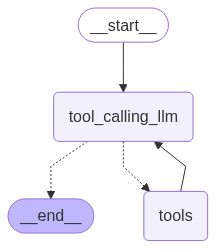

In [36]:
### Entire Chatbot with Langgraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

### Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                            # If the latest message (result) from assistant is NOT a tool call -> tools_condition routes to END
                              tools_condition)

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
from pprint import pprint
messages = graph.invoke({"messages": HumanMessage(content="Provide me the recent AI news for August 12, 2025, hey add 5 plus 5 and then multiply by 3")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me the recent AI news for August 12, 2025, hey add 5 plus 5 and then multiply by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1q9ywtp3n)
 Call ID: 1q9ywtp3n
  Args:
    query: recent AI news August 12 2025
  add (nvzg8jkkh)
 Call ID: nvzg8jkkh
  Args:
    a: 5
    b: 5
  multiply (4qfz2yfw2)
 Call ID: 4qfz2yfw2
  Args:
    a: 10
    b: 3
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "August 12, 2025 – PBS News Hour full episode", "url": "https://www.pbs.org/newshour/show/august-12-2025-pbs-news-hour-full-episode", "content": "August 12, 2025PBS News Hour full episode. Aug 12, 2025 7:28 PM EDT ... How to beat AI-driven custom pricing. 5 min. Support Provided By: Learn more.", "score": 0.97951}, {"title": "Artificial Intelligence News Highlig

In [44]:
messages = graph.invoke({"messages": HumanMessage(content="What is 5 plus 8")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (9ym1ndh7j)
 Call ID: 9ym1ndh7j
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The result of 5 plus 8 is 13.


In [45]:
messages = [HumanMessage(content="Divide that by 5")]
messages = graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

The phrase "that" is unclear in this context. Could you please specify the number you'd like me to divide by 5?


In [48]:
## Specify the thread

### Entire Chatbot with Langgraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

### Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                            # If the latest message (result) from assistant is NOT a tool call -> tools_condition routes to END
                              tools_condition)

builder.add_edge("tools", "tool_calling_llm")

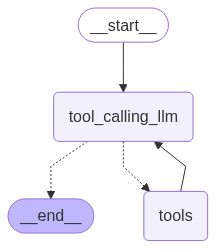

In [49]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [57]:
## Specify a thread

config={"configurable": {"thread_id": "2"}}

# Specify an input
messages = [HumanMessage(content="Add 12 and 13")]
messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (vyynd22w7)
 Call ID: vyynd22w7
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**. Let me know if you need help with anything else! 😊


In [58]:
messages = [HumanMessage(content="Add that number to 25")]
messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (vyynd22w7)
 Call ID: vyynd22w7
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**. Let me know if you need help with anything else! 😊
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (s7nj0kxsf)
 Call ID: s7nj0kxsf
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 to 25 is **50**. Let 

In [59]:
messages = [HumanMessage(content="then multiply that number by 2")]
messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (vyynd22w7)
 Call ID: vyynd22w7
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**. Let me know if you need help with anything else! 😊
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (s7nj0kxsf)
 Call ID: s7nj0kxsf
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 to 25 is **50**. Let 